<a href="https://colab.research.google.com/github/PriyanshLodhi32/Lipnet-Model-/blob/main/Enhanced_Lipnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model 1

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown

Ensure GPU memory growth is enabled if a GPU is available



In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

Download and extract the data

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')



Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=6cb95e26-406f-4755-98ad-c4939e682ce9
To: /content/data.zip
100%|██████████| 423M/423M [00:08<00:00, 52.8MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

Define a function to load video frames and process them


In [ ]:
def load_video(path: str) -> tf.Tensor:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frame = tf.image.resize(frame, [46, 140])
        frames.append(frame)
    cap.release()
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(frames)
    return (frames - mean) / std

Define vocabulary and mappings


In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


Define a function to load alignments

In [ ]:
def load_alignments(path: str) -> tf.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])
    return char_to_num(tf.strings.unicode_split(tokens, input_encoding='UTF-8'))[1:]

Define a function to load data


In [ ]:
def load_data(path: str):
    path = path.numpy().decode('utf-8')
    file_name = os.path.basename(path).split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

def tf_load_data(path: tf.Tensor):
    frames, alignments = tf.py_function(load_data, [path], [tf.float32, tf.int64])
    frames.set_shape([None, 46, 140, 1])
    alignments.set_shape([None])
    return frames, alignments

 Prepare the data pipeline


In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(tf_load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
data = data.padded_batch(2, padded_shapes=([None, 46, 140, 1], [None]))
data = data.prefetch(tf.data.experimental.AUTOTUNE)

Access the data


In [ ]:
def load_alignments(path: str) -> tf.Tensor:
  with open(path, 'r') as f:
      lines = f.readlines()
  tokens = []
  for line in lines:
      line = line.split()
      if line[2] != 'sil':
          tokens.extend([' ', line[2]])
  return char_to_num(tf.strings.unicode_split(tokens, input_encoding='UTF-8'))[1:].to_tensor()

In [ ]:
def load_alignments(path: str) -> tf.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])
    # Convert tokens to indices using char_to_num lookup layer
    alignments = char_to_num(tf.strings.unicode_split(tokens, input_encoding='UTF-8'))[1:]
    # Reshape the alignments tensor to ensure it has a rank of 1
    alignments = tf.reshape(alignments, shape=[-1])
    return alignments

Frames shape: (2, 75, 46, 140, 1)
Alignments shape: (2, 24)


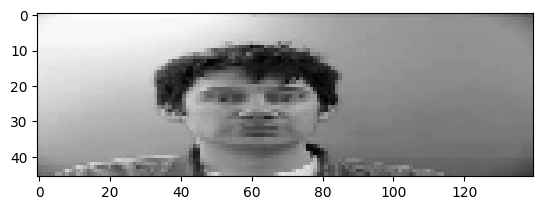

In [ ]:
for frames, alignments in data.take(1):
  print("Frames shape:", frames.shape)
  print("Alignments shape:", alignments.shape)
plt.imshow(tf.squeeze(frames[0][0]), cmap='gray')
plt.show()

In [ ]:
alignments

<tf.Tensor: shape=(2, 24), dtype=int64, numpy=
array([[ 2,  9, 14, 39, 18,  5,  4, 39,  2, 25, 39, 20, 39, 20,  8, 18,
         5,  5, 39,  1,  7,  1,  9, 14],
       [12,  1, 25, 39,  2, 12, 21,  5, 39,  2, 25, 39, 17, 39,  5,  9,
         7,  8, 20, 39, 14, 15, 23,  0]])>

Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
5*17*75

6375

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
train = data.take(450)
test = data.skip(450)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback,  schedule_callback, example_callback])

KeyboardInterrupt: 

Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
from tensorflow.keras.optimizers import legacy

In [ ]:
optimizer = legacy.Adam(learning_rate=0.001)

In [ ]:
test = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

Real Time Data Usage using Webcam


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

# Load the pre-trained model
model = ...  # Load your pre-trained LipNet model

# Load the character mapping layers
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")  # Load the char_to_num layer
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True) # Load the num_to_char layer

def load_video(cap: cv2.VideoCapture) -> List[float]:
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
        if len(frames) >= 75:
            break
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

def predict_lip_movement(frames: np.ndarray) -> str:
    frames = np.expand_dims(frames, axis=0)
    yhat = model.predict(frames)
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    return tf.strings.reduce_join([num_to_char(word) for word in decoded]).numpy().decode('utf-8')

def main():
    cap = cv2.VideoCapture(0)  # Use the webcam (index 0) as the video source

    while True:
        frames = load_video(cap)
        prediction = predict_lip_movement(frames)
        print(f"Prediction: {prediction}")

        cv2.imshow("Webcam Feed", frames[0])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

## Model 2

Image to Text Conversion

In [ ]:
!pip install tensorflow keras opencv-python numpy

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path,"/content/train-00000-of-00001-623e9e8093819ef0.parquet")
        if image is None:  # Check if image loading failed
            raise FileNotFoundError(f"Error: Could not load image at '{image_path}'")
    except FileNotFoundError as e:
        print(e)
        return None
    # Resize the image to the desired input size for the model
    image = cv2.resize(image, (128, 32))
    # Normalize the image
    image = image.astype(np.float32) / 255.0
    # Expand dimensions to match model input shape
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    return image

def build_model(input_shape):
    model = models.Sequential()
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())
    # Add dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # Output layer with 10 classes
    return model

# Example usage:
input_shape = (32, 128, 1)  # Height, Width, Channels
model = build_model(input_shape)
model.summary()

In [ ]:
import cv2
import numpy as np
import pytesseract

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:  # Check if image loading failed
        raise FileNotFoundError(f"Error: Could not load image at '{image_path}'")
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to enhance text visibility
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

def image_to_text(image_path):
    image = preprocess_image(image_path)
    text = pytesseract.image_to_string(image, lang='eng', config='--psm 11')
    return text
def image_to_text(image_path):
  """
  This function takes an image path and returns the text extracted from the image.

  Args:
      image_path: A string representing the path to the image file.

  Returns:
      A string containing the extracted text from the image.
  """

  # Add your image processing logic here to extract text from the image.
  # You can use libraries like OpenCV or Tesseract.

  # Example implementation using OpenCV:
import cv2

image = cv2.imread("C:\\Users\\ASUS\\Downloads\\calligraphic-background-motivational-quote\\2581388.jpg")

In [ ]:
import cv2
import numpy as np
import pytesseract

def preprocess_image(image_path):
    """
    This function takes an image path, loads the image, converts it to grayscale,
    and applies thresholding to enhance text visibility.

    Args:
        image_path: A string representing the path to the image file.

    Returns:
        A preprocessed image.
    """
    image = cv2.imread(image_path)
    if image is None:  # Check if image loading failed
        raise FileNotFoundError(f"Error: Could not load image at '{image_path}'")
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to enhance text visibility
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

def image_to_text(image_path):
    """
    This function takes an image path, preprocesses the image, and extracts text from it.

    Args:
        image_path: A string representing the path to the image file.

    Returns:
        A string containing the extracted text from the image.
    """
    image = preprocess_image(image_path)
    text = pytesseract.image_to_string(image, lang='eng', config='--psm 11')
def image_to_text(image_path):
    """
    This function extracts text from an image using the Tesseract OCR library.

    Args:
        image_path: Path to the image file.

    Returns:
        The extracted text from the image.
    """

    # Import the necessary modules
    import pytesseract

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Use Tesseract to extract text from the image
    extracted_text = pytesseract.image_to_string(image)


## Model 3

Text To Speech Conversion

In [ ]:
# https://readloud.net/english/british/1-male-voice-brian.html
# pip install selenium chromedriver_autoinstaller

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from time import sleep
from chromedriver_autoinstaller import install


# Install ChromeDriver
chrome_path = install()


# Set up Chrome options
chrome_options = Options()

chrome_options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3")
chrome_options.add_argument("--headless=new")


# Start the Service
service = Service(executable_path=chrome_path)

# Start the WebDriver
driver = webdriver.Chrome(service=service, options=chrome_options)

driver.get("https://readloud.net/english/british/1-male-voice-brian.html")

script = """function mediaElementIsPlaying(el) {
  return el && el.currentTime > 0 && !el.paused && !el.ended && el.readyState > 2;
}

// Check if any audio element is playing
const audioIsPlaying = !![...document.getElementsByTagName('audio')].find((el) => mediaElementIsPlaying(el));

// If either audio or video is playing, return true
return audioIsPlaying;"""

def TextToSpeech(text):
    try:
        textarea = driver.find_element(By.NAME, "but1")
        textarea.clear()
        textarea.send_keys(text)

        submit = driver.find_element(By.NAME, "butt0")
        submit.click()

        while 1:
            playing = driver.execute_script(script)
            if not playing:
                break
            sleep(0.1)

    except Exception as e:
        print(e)
        print("Restarting website")
        driver.get("https://readloud.net/english/british/1-male-voice-brian.html")
        TextToSpeech(text)

if _name_ == "_main_":
    while 1:
        text = input(">>>  ")
        TextToSpeech(text)